### TODO: DELETE THIS LINE AFTER ALL MEMBERS HAVE PUT INFO BELOW IN THIS FORMAT. 1 CELL PER PERSON.

NAME: Martin Mourgos

STUDENT ID: A12663172

CONTRIBUTIONS: Visualization of data. Created Beta/Gamma functions. Data analysis. Parts of write-up.

NAME: Ahrial Young

STUDENT ID: A12843588

CONTRIBUTIONS: Write Up

NAME: Yen Le

STUDENT ID: A10669230

CONTRIBUTIONS: data processing, data analysis, and creating an animation of the zombie apocalypse.

NAME:
    
STUDENT ID:
    
CONTRIBUTIONS:

NAME:
    
STUDENT ID:
    
CONTRIBUTIONS:

# Generation Zombie


## Overview

From literature works such as “The Zombie Survival Guide”, to popular TV shows like “The Walking Dead”, and movies including “World War Z”, the concept of a zombie apocalypse has captivated the imagination of millions.
 
Although the concept of an army of undead, semi-sentient, flesh-hungry beings bringing forward the end of humanity may seem like a fantastical notion, many experts have applied a zombie apocalypse model to study the spread of real infectious diseases [1]. In 2011, the Center for Disease Control (CDC) in the United States published an emergency preparedness guide for how to survive a zombie apocalypse, as a campaign to increase public interest and awareness in potential tools for a public health emergency [2]. 
 
With the intention of making public health more accessible, our project will model the spread of a zombie apocalypse in San Diego based on median age, population density, and median house value in 40 San Diego County regions. We have arbitrarily placed patient zero in Chula Vista.


### Research Question

Where, based on population density, median age, and median housing value, will be the last region in San Diego to be affected by the zombie apocalypse?

### Hypothesis

Our hypothesis is that Ramona will be the last region in San Diego affected by the zombie apocalypse because it has relatively low population density, relatively low median age, and average median housing value.

 
#### Underlying Assumptions:
 
"The Rules" are an important part of any zombie apocalypse, because every series seems to have different parameters governing their zombies. Our rules are quite simple, partially for simplicity's sake and partially to fit a zombie outbreak to the SIR model for infectious diseases.
    1. You become a zombie 24 hours after you are bitten by a zombie (Susceptible -> Infected).
    2. Zombies can only be killed by people, i.e. they do not die of old age or starvation (Infected -> Recovered). Note that in 
    our context, a "recovered zombie" is a dead one.
    3. No strings attached. As in, there are no plot twists like in television or movies! No turning zombies back or killing 
    their leader to free them all.

References: 
[1] http://www.latimes.com/science/sciencenow/la-sci-sn-zombie-apocalpyse-bmj-christmas-20151218-story.html
[2] http://www.abc.net.au/news/2015-12-17/zombie-apocalypse-study-draws-attention-serious-pandemics/7035488
[3] http://www.sandag.org/resources/demographics_and_other_data/demographics/census/zip/SRAPopRaceHousing2010.zip
[4]
https://drive.google.com/open?id=16TUQO0F4C7WkoIyXqushgFg45awXNkmB
[5]
https://statisticalatlas.com/place/California/San-Diego/Population

## Data

### Data Cleaning


### Methodology for Data Collection: 
 
Our primary sources of data were government websites with information collected during the 2010 United States Census. The first data set is an excel spreadsheet titled ‘2010 Census Subregional Areas Redistricting Data’, which notes the total population of 41 regions in San Diego County [3]. The second data set is an excel spreadsheet titled ‘Demographic and Socioeconomic Profile 2010 by SRA’, which notes information on median age and on median housing value for various subregions in San Diego county [4]. 
 
The majority of our data on population density was scraped from Statistical Atlas for specific subregions in San Diego County [5]. Since we could not find a database with calculations on population density for all 41 subregions we are analyzing, we will extrapolate population density from the population data in the ‘2010 Census Subregional Areas Redistricting Data’ and information noting subregion area scraped from Wikipedia. 

In [20]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import matplotlib.image as mpimg
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = 12, 8
from PIL import Image
import matplotlib.cm as cm
import imageio
import os

In [21]:
# Uploading the data. We first read the data in through an Excel file, then
# store the data category by category.
xls = pd.ExcelFile('The_data.xlsx')

# Age and Sex
df_age_sex = pd.read_excel(xls, 'Age and Sex')
df_age_sex = df_age_sex.drop('YEAR', 1)
df_age_sex.columns = ["Sra", "AGE GROUP", "TOTAL", "MALE", "FEMALE"]


# Elevation
df_elevation = pd.read_excel(xls, 'Elevation')
df_elevation['Elevation']=df_elevation['Elevation'].fillna("No Data")


# Marital Status
df_marital_status = pd.read_excel(xls, 'Marital Status')
df_marital_status = df_marital_status.drop('YEAR', 1)


# Educational Attainment
df_educational_attainment = pd.read_excel(xls, 'Educational Attainment')
df_educational_attainment = df_educational_attainment.drop('YEAR', 1)


# Types of Households
df_housing_units_type = pd.read_excel(xls, 'Housing Units Type')
df_housing_units_type = df_housing_units_type.drop('YEAR', 1)


# House Value
df_housing_value = pd.read_excel(xls, 'Housing Value')
df_housing_value = df_housing_value.drop('YEAR', 1)


# House Structure Age
df_year_house_built = pd.read_excel(xls, 'Year Structure Built')
df_year_house_built = df_year_house_built.drop('YEAR', 1)


# Vehicle Data
df_vehicles = pd.read_excel(xls, 'Vehicle Availability')
df_vehicles = df_vehicles.drop('YEAR', 1)

# Population Density
df_pop_density = pd.read_excel(xls, 'Population Density')



In [22]:
#The unique regions (SRAs) we have for the census data

regions = df_age_sex["Sra"].unique()
df_regions = pd.DataFrame(regions)
df_regions.columns = ["Region"]

In [23]:
#################################################################
# Our main dataframe that we'll use to create the SIR equations #
#################################################################

df = pd.DataFrame(data=regions, columns=["Region"])

In [24]:
#Adding median age to the df

median_age = df_age_sex[(len(df_age_sex) - 41):]
median_age = median_age["TOTAL"]
median_age.index=df.index

df['Median Age'] = (median_age)

In [25]:
#Adding house median value to the df

median_house_value = df_housing_value[(len(df_housing_value) - 41):]
median_house_value = median_house_value["NUMBER"]
median_house_value.index=df.index

df['Median House Value'] = (median_house_value)

In [26]:
#Population density...

df_pop_density = df_pop_density.sort_values("Neighborhood")

df['Population Density'] = ("n/a")
missing_data_df = pd.DataFrame([['Alpine', 569],['Anza-Borrego Springs',102],['Central San Diego',0],['Coastal',0],['Del Mar-Mira Mesa',6992],['Elliott-Navajo',6364],
                                ['Harbison-Crest',886],['Kearny Mesa',625],['Laguna-Pine Valley',24],['Mid-City',11237],['Miramar',397],['Mountain Empire',20],
                                ['North San Diego',0],['Palomar-Julian',11],['Pauma',82],['Peninsula',4696],['San Dieguito',0],['South Bay',0],
                                ['Southeastern San Diego',17908], ['Sweetwater',3362],['University',4378],['Valley Center',833]], columns = ['Neighborhood', 'People per square mile'])
df_pop_density = pd.concat([df_pop_density, missing_data_df])
df_pop_density




,Neighborhood,People per square mile
23,Bonita,2710
36,Borrego Springs,60
1,Bostonia,7930
34,Boulevard,80
22,Carlsbad,2840
20,Casa de Oro-Mt Helix,2870
8,Chula Vista,5000
21,Coronado,2860
26,Del Mar,2460
35,Descanso,60


In [27]:
pd.options.mode.chained_assignment = None  # default='warn'


common_sras = []
common_sras_indices = []

for index, row in df.iterrows():
    if(df_pop_density['Neighborhood'].str.contains(row["Region"]).any()):
        common_sras.append(row["Region"])
        common_sras_indices.append(index)

for i in range(0,len(common_sras)):
    df["Population Density"][common_sras_indices[i]] = df_pop_density[df_pop_density["Neighborhood"] == common_sras[i]]
    x = df["Population Density"][common_sras_indices[i]]
    df["Population Density"][common_sras_indices[i]] = int(x["People per square mile"])

        

In [28]:
# Calculating the total population of each region.

total_population = [0]*(len(regions))

k = 0
j = 0
for i in range(0, len(regions)): # i is for regions[]
    if(df_age_sex["Sra"][k] == regions[i]):
        j = k
        k = k + 20
        if(df_age_sex["Sra"][k] == "Mountain Empire"):
            #Because Miramar's data is wonky
            k = k - 4
        
        while(df_age_sex["Sra"][j] == regions[i]):
            total_population[i] += int(df_age_sex["TOTAL"][j])
            j += 1
            
#Add the Total Population column
df['Total Population'] = total_population

In [29]:
df

,Region,Median Age,Median House Value,Population Density,Total Population
0,Alpine,42.3,612870,569,15256
1,Anza-Borrego Springs,55.3,306852,102,4436
2,Carlsbad,40.8,613993,2840,114712
3,Central San Diego,34.4,521767,0,165582
4,Chula Vista,33.9,359311,5000,115234
5,Coastal,35.4,969973,0,75375
6,Coronado,31.3,1275412,2860,24697
7,Del Mar-Mira Mesa,37.0,639308,6992,158106
8,El Cajon,34.8,421170,6950,124552
9,Elliott-Navajo,37.4,516103,6364,89106


In [30]:
# Data cleaning: Drop any neighborhoods without population density data, as this is important for our analysis.
df = df[~(df[['Population Density']] == 0).any(axis=1)]
df


,Region,Median Age,Median House Value,Population Density,Total Population
0,Alpine,42.3,612870,569,15256
1,Anza-Borrego Springs,55.3,306852,102,4436
2,Carlsbad,40.8,613993,2840,114712
4,Chula Vista,33.9,359311,5000,115234
6,Coronado,31.3,1275412,2860,24697
7,Del Mar-Mira Mesa,37.0,639308,6992,158106
8,El Cajon,34.8,421170,6950,124552
9,Elliott-Navajo,37.4,516103,6364,89106
10,Escondido,33.5,437250,3940,162988
11,Fallbrook,41.5,584068,1730,47306


# Visualizations

Let's start by analyzing the data at face value, then we will move on to using our S-I-R function to make a decision.

<Container object of 3 artists>

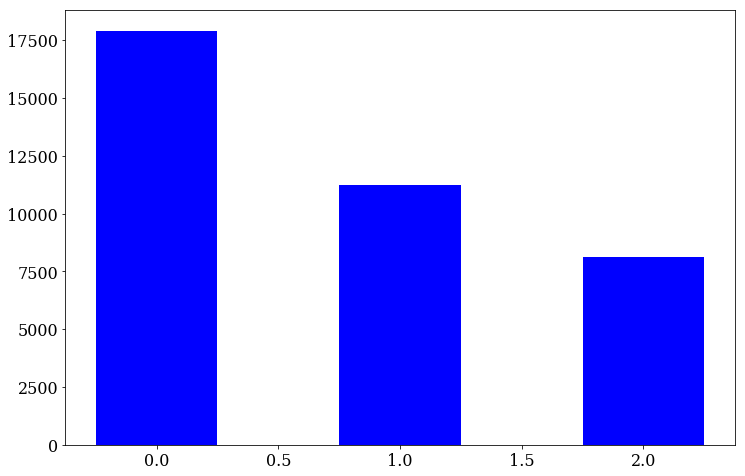

In [31]:
# Bar graph to compare top 3 population densities with bottom 3.
    # The regions with highest population densities are among the more risky places to be. Let's compare them.
top3 = [0,0,0]
bot3 = [100000,1000000,100000]
for row in df.iterrows():
    popDens = int(row[1]['Population Density'])
    if(popDens > top3[0]):
        top3.pop(2)
        top3.insert(0, popDens)
    elif( popDens > top3[1]):
        top3.pop(2)
        top3.insert(1, popDens)
    elif( popDens > top3[2]):
        top3.pop(2)
        top3.insert(2, popDens)
    
    if(popDens < bot3[0]):
        bot3.pop(2)
        bot3.insert(0, popDens)
    elif( popDens < bot3[1]):
        bot3.pop(2)
        bot3.insert(1, popDens)
    elif( popDens < bot3[2]):
        bot3.pop(2)
        bot3.insert(2, popDens)
x = range(3)            
 

plt.bar(x, top3, .5, color="Blue" )

<Container object of 3 artists>

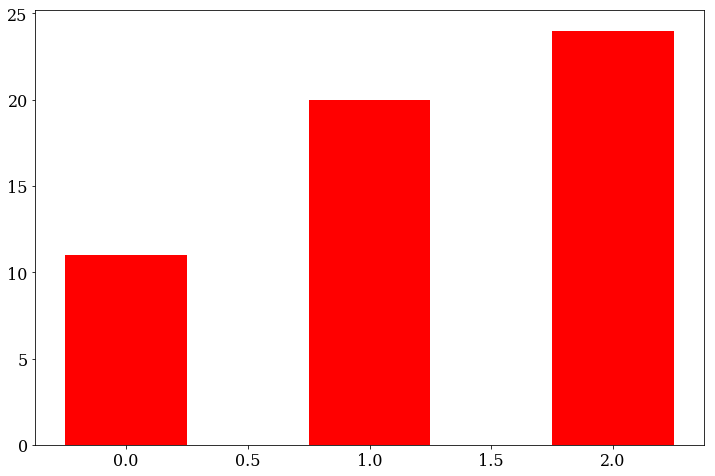

In [32]:
plt.bar(x, bot3, .5, color="Red" )

As you can see, there are enormous differences between the highest and lowest population densities in our data. 
Plotting all six on the same bar graph, the bottom three would not even be visible.
Population density on its own isn't enough to make any analytical guesses, however. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000001CBB1F0A90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000001CBB54FC18>]], dtype=object)

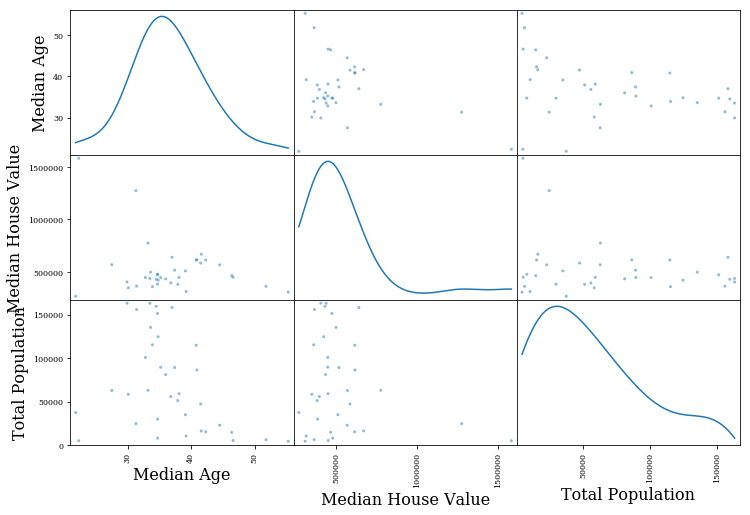

In [33]:
# Scatter plot of density, age, and house value. Explain relationships and why they are important in zombie apocalypse.
from pandas.plotting import scatter_matrix

scatter_matrix(df, diagonal='kde')

The scatter matrix above appears to show a positive relationshop between "Median Age" and "Median House Value". This makes sense, as older folks have had more lifetime to accrue money and thus have more valuable property. This relationship will affect our analysis, since an older population is a negative for survival but a richer population is a positive for survival.

# Data Analysis

Now it's time to analyze the data to decide which region is the safest. 
The S-I-R function utilizes Beta, the measure of the rate at which people will be turned into zombies,
and Gamma, the measure at which zombies will be killed. Each region is assigned a Beta and Gamma based on its statistics,
then is given a Danger Score: Beta - Gamma.
The region with the lowest danger score will be deemed to be the best place to go in a zombie apocalypse.

The formula for Beta and Gamma are based on our three statistics: Population density, Median House value, and Median Age. 

Negative factors for survival (factored into Beta)
- Population density: Having a dense population means that there are more zombies walking the streets, making it easier
                      to be cornered and eaten by the horde.
- Median House Value (Inverse!): Poorer populations are more vulnerable to zombie outbreaks since it is more difficult to get supplies,
                      transport, guns, etc.
- Median Age: An older population will have trouble getting away from zombies, making them more vulnerable.

Positive factors for zombie destruction (factored into Gamma)
- Median Age (inverse): A younger population will be more able to use weapons to kill zombies. 

Each factor has a weight; these factors multiplied by their weights combine into the Beta/Gamma.

The functions are: Beta = PopulationDensity x 10^-6 + MedianAge x 10^-4 + (1/Median House Value) x 10^2
                   Gamma = (1/MedianAge) x 10^-1

University: 0.007303883241668851 0.0036363636363636364


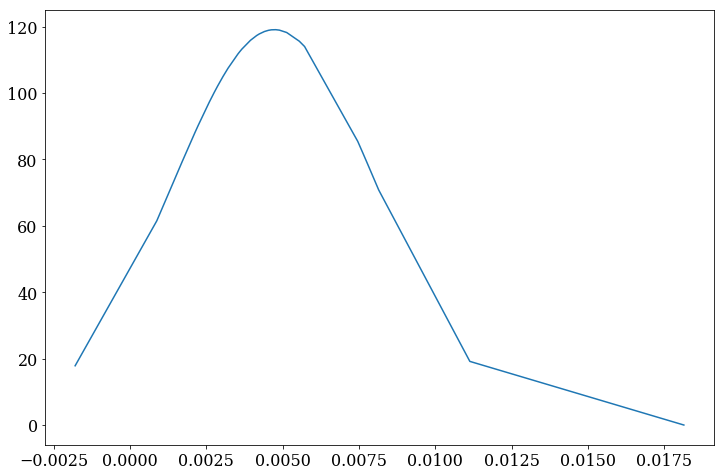

In [34]:
# Given a row (i.e. region), calculate its Danger value.
def DangerLevel(row):
    PopDensity = row[1]['Population Density']
    MedAge = row[1]['Median Age']
    MedHouse = row[1]['Median House Value']
    
    
    Beta = float(PopDensity)*0.0000010 + float(MedAge)*0.00010 + (1 / (float(MedHouse)))*100
    Gamma = (1 / float(MedAge)) * 0.1

    # For later purposes we want to know the University's beta and gamma values.
    if(row[1]['Region'] == 'University'):
        print( "University: " + str(Beta) + " " + str(Gamma) )
    
    return Beta - Gamma


# Save the lowest danger level and the name of its region 
lowestDangerLevel = 1000
lowestDangerRegion = ""

dangerLevels = []

for row in df.iterrows():
    danger = DangerLevel(row)
    dangerLevels.append(danger)
    if(danger < lowestDangerLevel):
        lowestDangerLevel = danger
        lowestDangerRegion = row[1]['Region']

# Plot the danger levels!
dangerLevels.sort()
meanDanger = np.mean(dangerLevels)
stdDanger = np.std(dangerLevels)
dangerpdf = scipy.stats.norm.pdf(dangerLevels, meanDanger, stdDanger)
plt.plot(dangerLevels, dangerpdf)


In [35]:
print("According to our analysis, the lowest danger level appears to be " + str(lowestDangerLevel) + " in " + str(lowestDangerRegion))

According to our analysis, the lowest danger level appears to be -0.001794147024702182 in Miramar


The distribution of danger levels appears to be approximately normal and unimodal.

In [36]:
gamma = 1

# Euler's function will be useful for the following step:
def euler_step(u, f, dt):
    return u + dt * f(u)

#define a map function to calculate each step
def f(u):
    S = u[0]
    I = u[1]
    R = u[2]
    
    new = np.array([-beta*(S[1:-1, 1:-1]*I[1:-1, 1:-1] + \
                            S[0:-2, 1:-1]*I[0:-2, 1:-1] + \
                            S[2:, 1:-1]*I[2:, 1:-1] + \
                            S[1:-1, 0:-2]*I[1:-1, 0:-2] + \
                            S[1:-1, 2:]*I[1:-1, 2:]),
                     beta*(S[1:-1, 1:-1]*I[1:-1, 1:-1] + \
                            S[0:-2, 1:-1]*I[0:-2, 1:-1] + \
                            S[2:, 1:-1]*I[2:, 1:-1] + \
                            S[1:-1, 0:-2]*I[1:-1, 0:-2] + \
                            S[1:-1, 2:]*I[1:-1, 2:]) - gamma*I[1:-1, 1:-1],
                     gamma*I[1:-1, 1:-1]
                    ])
    
    padding = np.zeros_like(u)
    padding[:,1:-1,1:-1] = new
    padding[0][padding[0] < 0] = 0
    padding[0][padding[0] > 255] = 255
    padding[1][padding[1] < 0] = 0
    padding[1][padding[1] > 255] = 255
    padding[2][padding[2] < 0] = 0
    padding[2][padding[2] > 255] = 255
    
    return padding


# More Visualization: The Outbreak Map

In [37]:
#creating a function that allows us to simulate a zombie apocalypse
def zombieApocalypse(denMap, xStart, yStart):
    from PIL import Image
    img = Image.open(denMap) 
    #attempt to resize
    basewidth = 500
    wpercent = (basewidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)

    img = np.asarray(img)

    #initializing the SIR model
    #establishes a patient 0
    S_0 = img[:,:,1]
    I_0 = np.zeros_like(S_0)
    I_0[yStart,xStart] = 1 # patient zero

    #set R to zero
    R_0 = np.zeros_like(S_0)


    #set some initial values
    T = 1000                        # final time
    dt = 1                          # time increment
    N = int(T/dt) + 1               # number of time-steps
    t = np.linspace(0.0, T, N)      # time discretization

    # initialize the array containing the solution for each time-step
    u = np.empty((N, 3, S_0.shape[0], S_0.shape[1]))
    u[0][0] = S_0
    u[0][1] = I_0
    u[0][2] = R_0

    #custom color mapping
    theCM = cm.get_cmap("Reds")
    theCM._init()
    alphas = np.abs(np.linspace(0, 1, theCM.N))
    theCM._lut[:-3,-1] = alphas

    #begins euler steps
    for n in range(N-1):
        u[n+1] = euler_step(u[n], f, dt)
    
    images = []
    keyFrames = []
    frames = 60.0
    for i in range(0, N-1, int(N/frames)):
        imgplot = plt.imshow(img, vmin=0, vmax=255)
        imgplot.set_interpolation('nearest')
        imgplot = plt.imshow(u[i][1], vmin=0, cmap=theCM)
        imgplot.set_interpolation("nearest")
        filename = "outbreak" + str(i) + '.png'
        plt.savefig(filename)
        keyFrames.append(filename)
    for filename in keyFrames:
        images.append(imageio.imread(filename))
    imageio.mimsave('outbreak.gif', images)

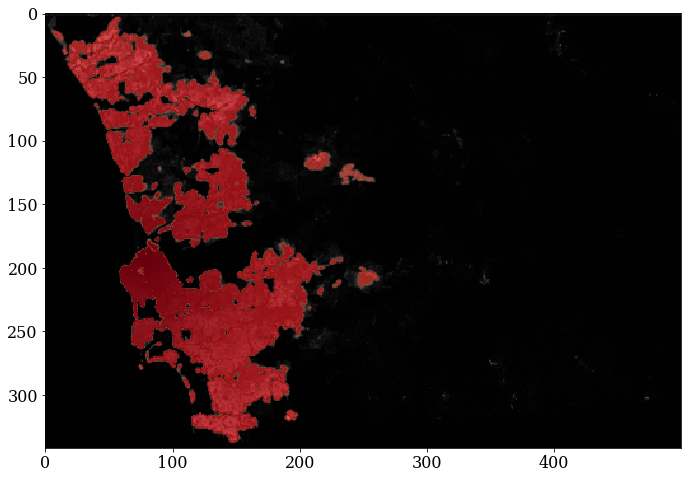

In [39]:
#establishing our beta value for our Patient Zero at UCSD
beta = 0.0073

#calling our zombie functiton
zombieApocalypse('dot_inv_no_label.jpg', 75, 190)
from IPython.display import Image
from IPython.display import display
display(Image(url='outbreak.gif'))